In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from simulation import *

In [2]:
# Import data from simulation folder
x = torch.load('simulation/x.pt', weights_only=False)
T = torch.load('simulation/t.pt', weights_only=False)
U = torch.load('simulation/U.pt', weights_only=False)
V = torch.load('simulation/V.pt', weights_only=False)

In [3]:
# First, check the shapes
print("U shape:", U.shape)  # Should be (nt, nx)
print("V shape:", V.shape)

# Extend U and V to include boundary conditions along spatial dimension
U = torch.cat((torch.zeros(U.shape[0], 1), U, torch.zeros(U.shape[0], 1)), dim=1)  # Add spatial boundaries
V = torch.cat((torch.zeros(V.shape[0], 1), V, torch.zeros(V.shape[0], 1)), dim=1)  # Add spatial boundaries

print("U shape after padding:", U.shape)  # Should be (nt, nx+2)
print("V shape after padding:", V.shape)

U shape: torch.Size([152, 121])
V shape: torch.Size([152, 121])
U shape after padding: torch.Size([152, 123])
V shape after padding: torch.Size([152, 123])


In [4]:
data = torch.stack((U, V), axis=2)  # shape (nt, nx, 2)
print(data.shape)  # (nt, nx, 2)

torch.Size([152, 123, 2])


In [5]:
nx = 2 # number of spatial points in each direction plus the same point
nt = 2 # number of time steps before prediction

number_connections = 2*nx*nt+nt

# Example of connection for the point (i,j) (time, space)

X = []  # shape (nt-1, nx, 2)
Y = []

for k in range(2, x.shape[0]-1):
    # First layer
    for i in range(x.shape[0]):

        X_ = []
        for j in range(2*nx+1):
            X_.append(U[k-1, i-nx+j])
        for j in range(2*nx+1):
            X_.append(U[k-2, i-nx+j])
        for j in range(2*nx+1):
            X_.append(V[k-1, i-nx+j])
        for j in range(2*nx+1):
            X_.append(V[k-2, i-nx+j])

            
        X.append(X_)
        Y.append([U[k, i], V[k, i]])

X = torch.tensor(X).float()  # shape (1, number_connections)
Y = torch.tensor(Y).float()  # shape (1,)

print(X.shape)  # (1, number_connections)
print(Y.shape)  # (1,)

torch.Size([14278, 20])
torch.Size([14278, 2])


In [6]:
# Create dataloaders
from torch.utils.data import DataLoader, TensorDataset, random_split
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [23]:
class ResidualNN(nn.Module):
    def __init__(self, arch=[60], nx=2, nt=2):
        super().__init__()
        self.in_layer = nn.Linear(2*2*(2*nx+1), arch[0])
        
        # Create hidden layers dynamically
        self.hidden_layers = nn.ModuleList()
        for i in range(len(arch)-1):
            self.hidden_layers.append(nn.Linear(arch[i], arch[i+1]))
        
        self.out_layer = nn.Linear(arch[-1], 2)
        
        
    def forward(self, x):
        # Forward pass through input layer
        x1 = F.relu(self.in_layer(x))
        
        # Forward pass through hidden layers with residual connection
        x2 = x1
        for layer in self.hidden_layers:
            x2 = F.relu(layer(x2)) + x1  # Residual connection to first hidden layer
        
        # Output layer - direct prediction (not residual)
        out = self.out_layer(x2)
        
        return out

In [24]:
model = ResidualNN()
criterion = nn.MSELoss()

In [39]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

In [40]:
# Setup device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


ResidualNN(
  (in_layer): Linear(in_features=20, out_features=60, bias=True)
  (hidden_layers): ModuleList()
  (out_layer): Linear(in_features=60, out_features=2, bias=True)
)

In [45]:
for epoch in range(1500):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        opt.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch 10, Train Loss: 0.000030, Val Loss: 0.000061
Epoch 20, Train Loss: 0.000030, Val Loss: 0.000060
Epoch 30, Train Loss: 0.000029, Val Loss: 0.000061
Epoch 40, Train Loss: 0.000029, Val Loss: 0.000061
Epoch 50, Train Loss: 0.000029, Val Loss: 0.000060
Epoch 60, Train Loss: 0.000029, Val Loss: 0.000060
Epoch 70, Train Loss: 0.000029, Val Loss: 0.000059
Epoch 80, Train Loss: 0.000029, Val Loss: 0.000059
Epoch 90, Train Loss: 0.000029, Val Loss: 0.000058
Epoch 100, Train Loss: 0.000028, Val Loss: 0.000058
Epoch 110, Train Loss: 0.000028, Val Loss: 0.000058
Epoch 120, Train Loss: 0.000028, Val Loss: 0.000057
Epoch 130, Train Loss: 0.000028, Val Loss: 0.000057
Epoch 140, Train Loss: 0.000028, Val Loss: 0.000056
Epoch 150, Train Loss: 0.000028, Val Loss: 0.000056
Epoch 160, Train Loss: 0.000028, Val Loss: 0.000056
Epoch 170, Train Loss: 0.000027, Val Loss: 0.000057
Epoch 180, Train Loss: 0.000027, Val Loss: 0.000056
Epoch 190, Train Loss: 0.000027, Val Loss: 0.000055
Epoch 200, Train Loss

KeyboardInterrupt: 

In [46]:
y_pred_list = []

for i in range(0, X.shape[0], 123):
    X_batch = X[i:i+123]
    with torch.no_grad():
        y_batch = model(X_batch)
    y_pred_list.append(y_batch)

# Concatenar tensors PyTorch
y_pred = torch.cat(y_pred_list, dim=0)
print(y_pred.shape)  # (num_samples, 2)

#y_pred = y_pred.view(-1, 123, 2)  # Reshape to (151-2, 123, 2)
print(y_pred.shape)  # (nt-2, nx, 2)

torch.Size([14278, 2])
torch.Size([14278, 2])


torch.Size([118, 121, 2])


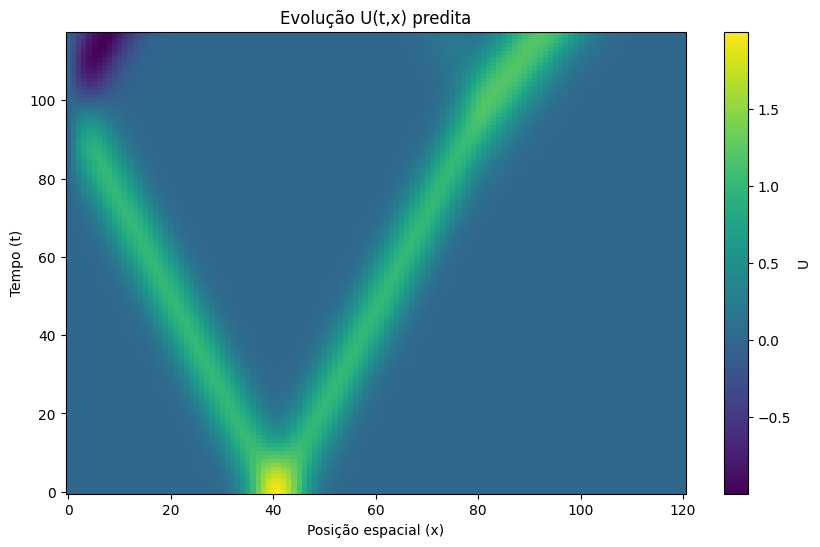

In [47]:
y_pred = y_pred.view(-1, x.shape[0], 2)  # Reshape to (nt-2, nx, 2)
print(y_pred.shape)  # (nt-2, nx, 2)

# Extrair apenas a componente U (índice 0) da predição
U_pred_final = y_pred[:, :, 0]  # shape (time_steps, spatial_size)

# Plot apenas o heatmap da evolução U(t,x)
plt.figure(figsize=(10, 6))
plt.imshow(U_pred_final.numpy(), aspect='auto', origin='lower')
plt.colorbar(label='U')
plt.xlabel('Posição espacial (x)')
plt.ylabel('Tempo (t)')
plt.title('Evolução U(t,x) predita')
plt.show()

U_predicted shape: torch.Size([118, 123])
V_predicted shape: torch.Size([118, 123])
U_pred_direct shape: torch.Size([118, 121])


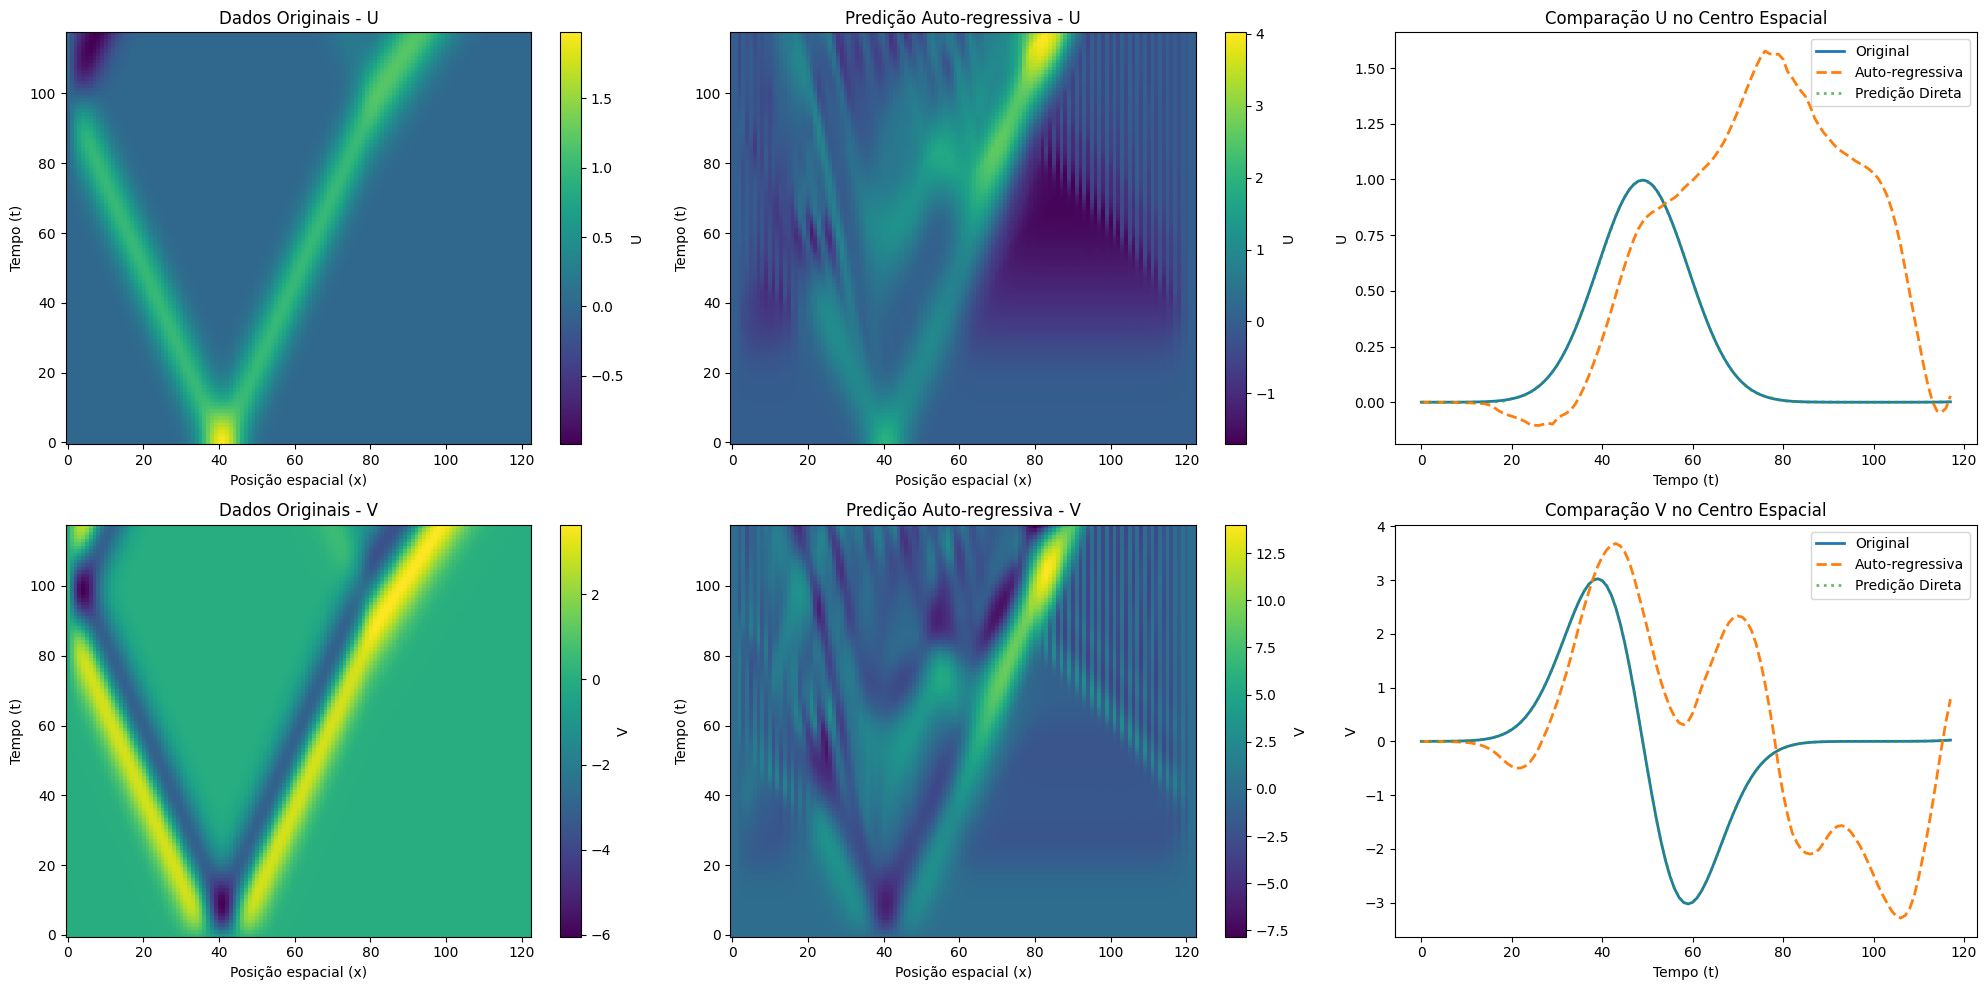

In [48]:
# Simulação auto-regressiva completa
def predict_full_dynamics(model, initial_conditions_U, initial_conditions_V, num_time_steps, spatial_size, nx=2):
    """
    Predição auto-regressiva da dinâmica completa
    
    Args:
        model: modelo treinado
        initial_conditions_U: condições iniciais U [U_t0, U_t1] shape (2, spatial_size)
        initial_conditions_V: condições iniciais V [V_t0, V_t1] shape (2, spatial_size)
        num_time_steps: número de passos temporais para predizer
        spatial_size: tamanho espacial
        nx: número de vizinhos espaciais
    """
    
    # Inicializar com as condições iniciais (2 primeiros time steps)
    U_history = torch.zeros(num_time_steps + 2, spatial_size)
    V_history = torch.zeros(num_time_steps + 2, spatial_size)
    
    # Definir condições iniciais
    U_history[0] = initial_conditions_U[0]  # t=0
    U_history[1] = initial_conditions_U[1]  # t=1
    V_history[0] = initial_conditions_V[0]  # t=0
    V_history[1] = initial_conditions_V[1]  # t=1
    
    # Predição auto-regressiva
    for t in range(2, num_time_steps + 2):
        # Predizer para cada posição espacial
        for i in range(nx, spatial_size - nx):  # Evitar bordas
            # Construir features para posição i no tempo t
            features = []
            
            # Vizinhos espaciais de U em t-1
            for j in range(2*nx + 1):
                features.append(U_history[t-1, i-nx+j].item())
            
            # Vizinhos espaciais de U em t-2
            for j in range(2*nx + 1):
                features.append(U_history[t-2, i-nx+j].item())
                
            # Vizinhos espaciais de V em t-1
            for j in range(2*nx + 1):
                features.append(V_history[t-1, i-nx+j].item())
            
            # Vizinhos espaciais de V em t-2
            for j in range(2*nx + 1):
                features.append(V_history[t-2, i-nx+j].item())
            
            # Converter para tensor e predizer
            input_tensor = torch.tensor(features).float().unsqueeze(0)
            
            with torch.no_grad():
                pred = model(input_tensor).squeeze(0)
            
            # Atualizar com predição
            U_history[t, i] = pred[0]
            V_history[t, i] = pred[1]
    
    return U_history[2:], V_history[2:]  # Retornar apenas os passos preditos

# Fazer primeiro a predição direta para ter como referência
y_pred_list = []

for i in range(0, X.shape[0], 123):
    X_batch = X[i:i+123]
    with torch.no_grad():
        y_batch = model(X_batch)
    y_pred_list.append(y_batch)

y_pred = torch.cat(y_pred_list, dim=0)
y_pred_reshaped = y_pred.view(-1, x.shape[0], 2)
U_pred_direct = y_pred_reshaped[:, :, 0]  # Predição direta

# Agora fazer a predição auto-regressiva com condições iniciais para U e V
initial_U = U[:2, :]  # shape (2, spatial_size)
initial_V = V[:2, :]  # shape (2, spatial_size)
num_prediction_steps = U_pred_direct.shape[0]  # Mesmo número de steps da predição direta

U_predicted, V_predicted = predict_full_dynamics(
    model, initial_U, initial_V, num_prediction_steps, U.shape[1], nx=2
)

print(f"U_predicted shape: {U_predicted.shape}")
print(f"V_predicted shape: {V_predicted.shape}")
print(f"U_pred_direct shape: {U_pred_direct.shape}")

# Plot da evolução espaço-temporal corrigida
plt.figure(figsize=(20, 10))

# Plot 1: Dados originais U
plt.subplot(2, 3, 1)
U_original_subset = U[2:2+U_pred_direct.shape[0]].numpy()
plt.imshow(U_original_subset, aspect='auto', origin='lower')
plt.colorbar(label='U')
plt.title('Dados Originais - U')
plt.xlabel('Posição espacial (x)')
plt.ylabel('Tempo (t)')

# Plot 2: Predição auto-regressiva U
plt.subplot(2, 3, 2)
plt.imshow(U_predicted.numpy(), aspect='auto', origin='lower')
plt.colorbar(label='U')
plt.title('Predição Auto-regressiva - U')
plt.xlabel('Posição espacial (x)')
plt.ylabel('Tempo (t)')

# Plot 3: Comparação temporal U no centro espacial
plt.subplot(2, 3, 3)
center_pos = U.shape[1] // 2
plt.plot(U_original_subset[:, center_pos], label='Original', linewidth=2)
plt.plot(U_predicted[:, center_pos].numpy(), label='Auto-regressiva', linestyle='--', linewidth=2)
plt.plot(U_pred_direct[:, center_pos].numpy(), label='Predição Direta', linestyle=':', linewidth=2, alpha=0.7)
plt.xlabel('Tempo (t)')
plt.ylabel('U')
plt.title('Comparação U no Centro Espacial')
plt.legend()

# Plot 4: Dados originais V
plt.subplot(2, 3, 4)
V_original_subset = V[2:2+U_pred_direct.shape[0]].numpy()
plt.imshow(V_original_subset, aspect='auto', origin='lower')
plt.colorbar(label='V')
plt.title('Dados Originais - V')
plt.xlabel('Posição espacial (x)')
plt.ylabel('Tempo (t)')

# Plot 5: Predição auto-regressiva V
plt.subplot(2, 3, 5)
plt.imshow(V_predicted.numpy(), aspect='auto', origin='lower')
plt.colorbar(label='V')
plt.title('Predição Auto-regressiva - V')
plt.xlabel('Posição espacial (x)')
plt.ylabel('Tempo (t)')

# Plot 6: Comparação temporal V no centro espacial
plt.subplot(2, 3, 6)
V_pred_direct = y_pred_reshaped[:, :, 1]  # Predição direta V
plt.plot(V_original_subset[:, center_pos], label='Original', linewidth=2)
plt.plot(V_predicted[:, center_pos].numpy(), label='Auto-regressiva', linestyle='--', linewidth=2)
plt.plot(V_pred_direct[:, center_pos].numpy(), label='Predição Direta', linestyle=':', linewidth=2, alpha=0.7)
plt.xlabel('Tempo (t)')
plt.ylabel('V')
plt.title('Comparação V no Centro Espacial')
plt.legend()

plt.tight_layout()
plt.show()